# 📝 Handwritten Text Recognition with TrOCR and Custom Dataset

This notebook presents a full pipeline for handwritten text recognition using **Microsoft's TrOCR (Transformer OCR)** model. It walks through loading and preprocessing data, creating a custom PyTorch dataset, fine-tuning the TrOCR model, and visualizing predictions.
## 📦 1. Import Required Libraries

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from datasets import load_metric
from transformers import AdamW
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd






# 📄 2. Load and Process Dataset from Text File
We read a text file containing image names and corresponding text labels. Each line has a format like lineX: text, which is split into an image name and the corresponding label.

In [ ]:
# Load and process the text file into DataFrame
file_path = '/content/drive/MyDrive/combined_bboxes1/dwe_list.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

processed_lines = []
line_numbers = []

for line in lines:
    colon_pos = line.find(':')
    if colon_pos != -1:
        line_number = line[:colon_pos].strip().replace('line', '')
        processed_line = line[colon_pos + 1:].strip()
        processed_lines.append(processed_line)
        line_numbers.append(line_number)

image_dir = '/content/drive/MyDrive/combined_bboxes1'
image_names = [f'line{line_number}' for line_number in line_numbers]

data = {'processed_lines': processed_lines, 'image_names': image_names}
df = pd.DataFrame(data)

train_df, test_df = train_test_split(df, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

processed_lines image_names
0     Bronchofort      line18
1           Zitro      line19
2        Novaclav      line52
3     Allergosone      line53
4      Salbutamol      line54

# 🧰 3. Define Custom Dataset Class
A PyTorch Dataset class is defined to handle:

- Image loading

- Preprocessing and resizing

- Tokenization of text labels

In [ ]:
# Define the CustomDataset class with transformations
class CustomDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128, target_size=(384, 384)):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_names'][idx]
        text = self.df['processed_lines'][idx]

        image_path = os.path.join(self.root_dir, file_name + '.jpg')
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        processed_image = self.transform(image)

        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": processed_image, "labels": torch.tensor(labels)}
        return encoding








# 🔧 4. Initialize Processor and Datasets Visualize Sample Image and Label
- We load the TrOCR processor and initialize training and evaluation datasets.
- We check one training sample by displaying the image and printing its decoded label.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


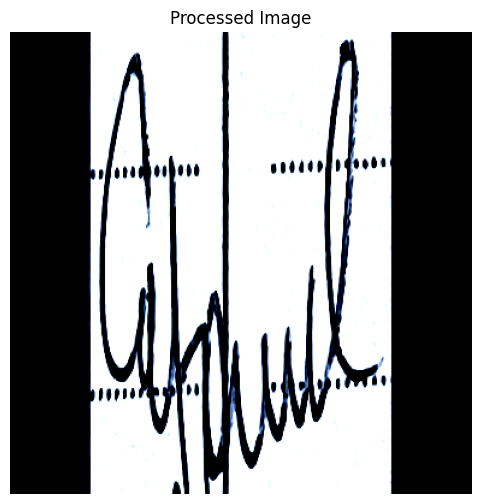

In [ ]:
# Initialize processor and datasets
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = CustomDataset(root_dir=image_dir, df=train_df, processor=processor)
eval_dataset = CustomDataset(root_dir=image_dir, df=test_df, processor=processor)

# Display images to verify processing
encoding = train_dataset[0]
plt.figure(figsize=(6, 6))
plt.imshow(encoding['pixel_values'].permute(1, 2, 0).numpy())
plt.title('Processed Image')
plt.axis('off')
plt.show()

# 📥 6. Create DataLoaders
after checking the decoded label

In [ ]:
# Decode labels to verify
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)

# Initialize DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

Cetamol


# 🤖 7. Load and Configure the TrOCR Model
We load a pre-trained TrOCR model and configure it for training.

In [ ]:
# Model and training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
model.to(device)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4




config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-7-1f02f879c701>:16: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer", trust_remote_code=True)


# 🔍 8. Define Character Error Rate (CER) Metric
We use the CER metric to evaluate the model’s text generation performance.

In [ ]:
# Define CER metric
cer_metric = load_metric("cer", trust_remote_code=True)

def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return cer

# 🔁 9. Training Loop
We train the model using AdamW optimizer for 100 epochs and evaluate after each epoch using CER.

In [ ]:
# Training loop
optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(100):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        for k, v in batch.items():
            batch[k] = v.to(device)

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    print(f"Loss after epoch {epoch}:", train_loss / len(train_dataloader))

    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            outputs = model.generate(batch["pixel_values"].to(device))
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer

    print("Validation CER:", valid_cer / len(eval_dataloader))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 0: 3.0142861555020013


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1283: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Validation CER: 0.7966792803534655


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 1: 1.2810875355886917


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.5664468010019178


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 2: 0.7938720308658149


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.44474169261045005


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 3: 0.6744488821002759


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.477315251828565


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 4: 0.46929145153586027


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.41913740705019614


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 5: 0.3645686129004591


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.42575158363356824


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 6: 0.1689785142039505


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3958461369447256


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 7: 0.16136350198656954


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.47619402844500985


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 8: 0.23610285977419052


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.414980402977888


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 9: 0.20367506043597436


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.37924265788729145


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 10: 0.1752030224371184


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.39489846594297284


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 11: 0.12333482455061232


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.42540239534412866


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 12: 0.19870312311589564


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.40400551883649827


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 13: 0.16053098877617028


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.43369818709080926


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 14: 0.11620562921921697


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.38557689413831975


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 15: 0.12032716584265775


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.39544636302221786


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 16: 0.11115096848779002


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3279534245319582


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 17: 0.1937364217277112


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.4222150010490697


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 18: 0.13564182896920507


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3020515270002915


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 19: 0.6123075489983117


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.527110702978998


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 20: 0.4952017572666389


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.4571695299812846


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 21: 0.26300980619918035


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.46628978110707153


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 22: 0.25645444482385454


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3395874615233108


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 23: 0.10626891072913874


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3730939362938329


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 24: 0.06688188027765642


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3275689612490428


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 25: 0.09252779991907624


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.33691180131943027


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 26: 0.04022748473481544


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3194765356664926


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 27: 0.03339942181820435


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.29876348886125065


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 28: 0.016433361976699718


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2886699849840406


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 29: 0.006469629843290174


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2699840528112663


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 30: 0.003974722858092466


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28539482238225256


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 31: 0.0055555415238662436


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28046061185593674


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 32: 0.004463737012662882


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.287979408848418


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 33: 0.002725630100201215


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28030112222276293


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 34: 0.0038869550859127835


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2862250228835057


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 35: 0.005920611769624884


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2810523861319216


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 36: 0.002322362836732989


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.27994670081570994


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 37: 0.0041901194063850905


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2780825791693742


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 38: 0.0025868382849125737


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28052110792369234


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 39: 0.004460365016629769


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2862250228835057


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 40: 0.004920663358209115


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2965124923361294


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 41: 0.002303607214767251


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2674689824556386


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 42: 0.0044852821003094805


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.27479310548516367


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 43: 0.0026429345817165187


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2674689824556386


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 44: 0.0038918704118771075


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2785717901849009


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 45: 0.002062213260071783


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2785717901849009


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 46: 0.0034713282598283334


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.27065877511911546


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 47: 0.006352419978466312


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2785717901849009


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 48: 0.0023914096237641993


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.29469761030346153


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 49: 0.004005093727926123


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2656541004229707


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 50: 0.004587521899106643


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2674689824556386


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 51: 0.004593433423593751


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2660554305456631


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 52: 0.005232902765101244


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.27551958968087487


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 53: 0.00433370761229273


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2735742275381443


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 54: 0.0012238882029799293


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2711249224572603


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 55: 0.005203689680563962


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.26165680772598765


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 56: 0.0019990897918091832


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2712261857164183


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 57: 0.00520856513586586


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.26165680772598765


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 58: 0.0023528114546738583


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28636504296053866


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 59: 0.0044712695242578905


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.27441891017462267


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 60: 0.0041953985727521586


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2632181777084104


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 61: 0.004001212670379475


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2722849623169906


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 62: 0.006805720729065317


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2647661653245094


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 63: 0.003533802683447915


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2612688599696189


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 64: 0.0025798171161347406


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.27233187103262996


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 65: 0.0035801506307851444


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2779709687769909


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 66: 0.007273701043434105


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.26855269455608505


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 67: 0.004701026161034368


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.27198038142030445


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 68: 0.000308171467821694


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.283676287853053


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 69: 0.007123847470189225


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2936336135998524


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 70: 0.0012787846012353536


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2759668977907217


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 71: 0.0035778421000461297


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2989164083563313


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 72: 0.0015755078139597521


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.27198038142030445


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 73: 0.0048655215457497685


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2734418039394506


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 74: 0.00018027434967077878


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3103688009477169


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 75: 0.005009434262593654


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.26224469351633395


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 76: 0.00680760252165808


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2622801356570393


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 77: 0.0042232379864459955


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2839667377238114


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 78: 0.0029016996988910173


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2723275317725468


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 79: 0.005541716071309427


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2824754505891963


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 80: 0.001493165088720932


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.29509503611899857


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 81: 0.002992596032855646


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2835320377138949


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 82: 0.0042696285268925115


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2819371413821565


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 83: 0.006914886226858307


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2856719485225363


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 84: 0.002463125959036145


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2688187598427223


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 85: 0.007736375676388679


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.26717402300061704


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 86: 0.0073981166723563595


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2657227846105242


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 87: 0.0036152397769263368


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.3073646938994922


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 88: 0.004547908965979748


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.26562603538451796


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 89: 0.00651596518435661


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28083071374709107


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 90: 0.0037388855764201403


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28029954010303654


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 91: 0.0034930670250601123


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28424947341585066


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 92: 0.0030107099457734104


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.29020995713419656


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 93: 0.003544561888560338


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.30390209002137586


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 94: 0.0032836559399835132


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2955812072676438


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 95: 0.002547888106222492


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.2886619695180975


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 96: 0.00013911444991165922


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.28709442362922194


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 97: 0.006480697724206329


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.29394476427457644


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 98: 0.0026999283001971877


  0%|          | 0/19 [00:00<?, ?it/s]

Validation CER: 0.278514050701448


  0%|          | 0/72 [00:00<?, ?it/s]

Loss after epoch 99: 0.004849091263687278


  0%|          | 0/19 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.29668467141290367


# 💾 10. Save the Trained Model

In [ ]:
model.save_pretrained("/content/drive/MyDrive/combined_bboxes1/model_mic_dwe.pt")

# 📤 11. Generate Predictions on Evaluation Set Visualize  with Ground Truth

Sample 1: Stop Algic
Sample 2: Angiotec
Sample 3: Clarid
Sample 4: Zitro
Sample 5: Augmentin
Sample 6: Salbutamol
Sample 7: Pivalone
Sample 8: Bronchofort
Sample 9: Perinase
Sample 10: Duofor


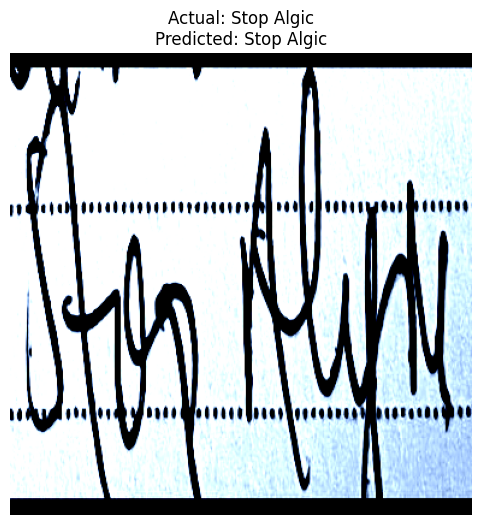

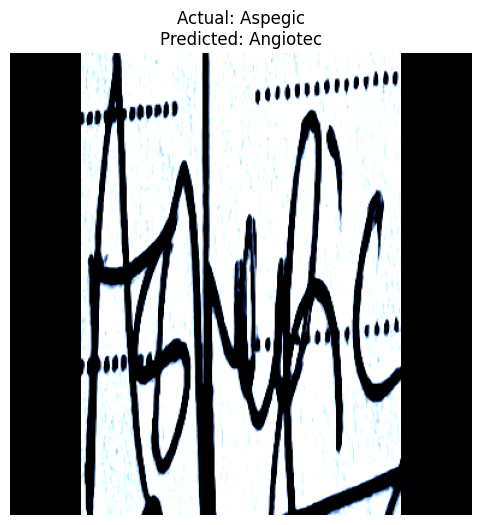

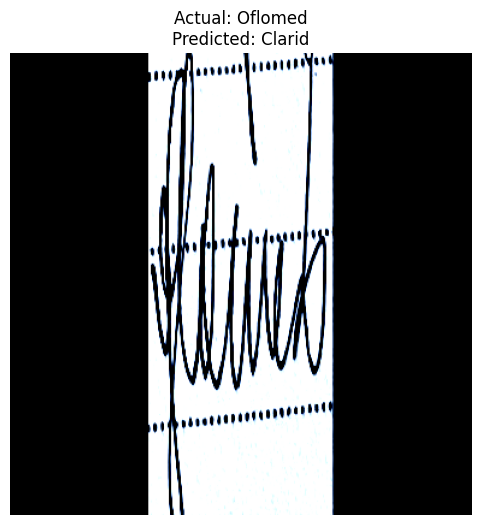

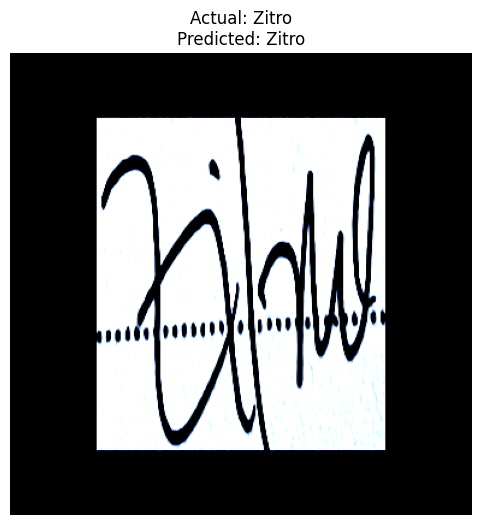

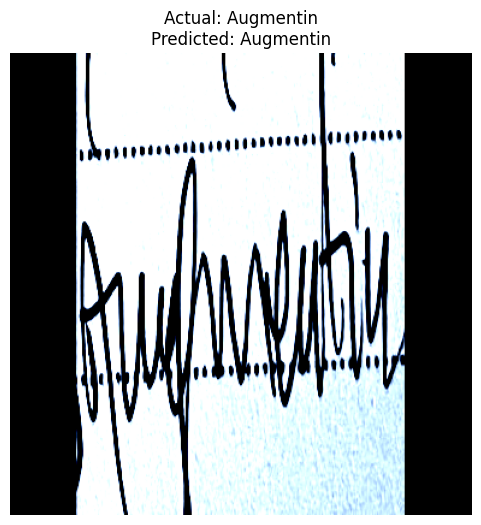

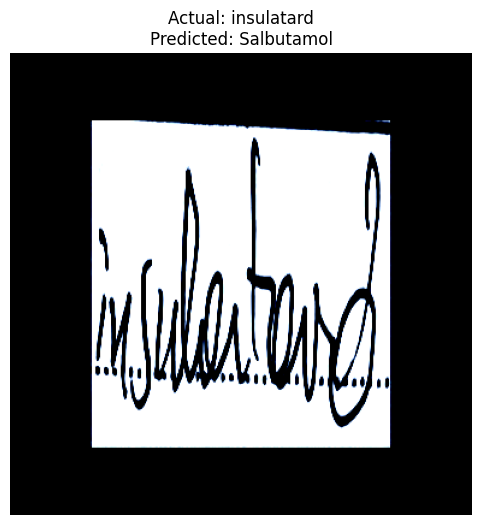

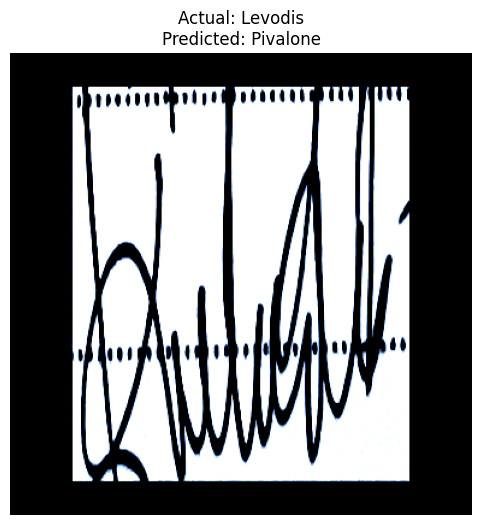

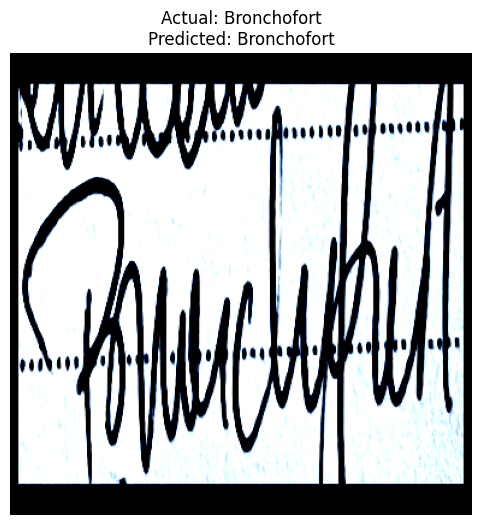

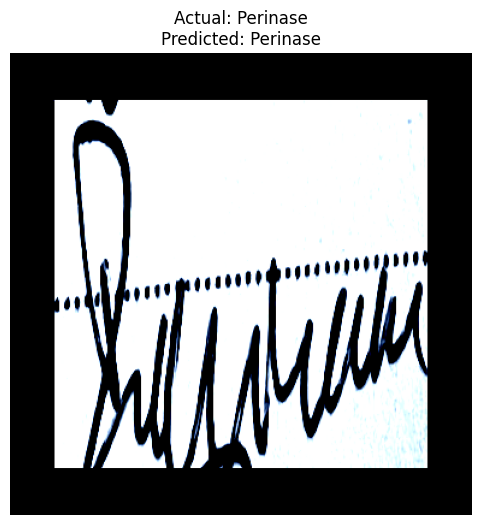

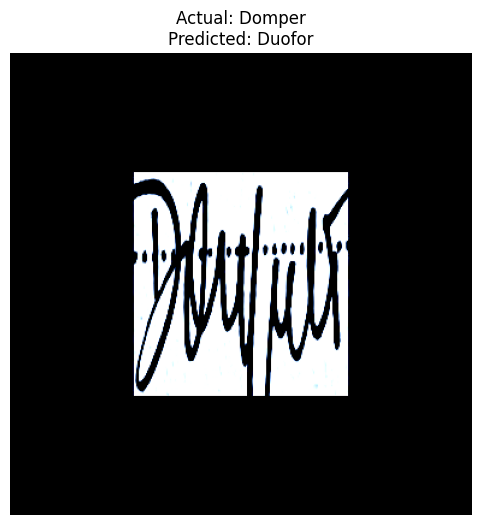

In [ ]:
# Function to generate predictions
def generate_predictions(dataset, model, processor, device, num_samples=5):
    model.eval()
    predictions = []

    for i in range(num_samples):
        sample = dataset[i]
        input_image = sample['pixel_values'].unsqueeze(0).to(device)

        with torch.no_grad():
            output_ids = model.generate(input_image, max_length=model.config.max_length)

        pred_str = processor.decode(output_ids[0], skip_special_tokens=True)
        predictions.append(pred_str)

    return predictions

# Generate predictions on the evaluation dataset
num_samples = 10  # Number of samples to generate predictions for
predictions = generate_predictions(eval_dataset, model, processor, device, num_samples)

# Display the predictions
for i, pred in enumerate(predictions):
    print(f"Sample {i + 1}: {pred}")

# Display the corresponding images and actual texts for comparison
for i in range(num_samples):
    sample = eval_dataset[i]
    input_image = sample['pixel_values']
    labels = sample['labels']

    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.decode(labels, skip_special_tokens=True)

    plt.figure(figsize=(6, 6))
    plt.imshow(input_image.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Actual: {label_str}\nPredicted: {predictions[i]}")
    plt.axis('off')
    plt.show()


# ✅ Summary
This notebook demonstrates how to:

- Preprocess handwritten text image data.

- Define a custom PyTorch dataset for TrOCR.

- Fine-tune TrOCR on a labeled image-text dataset.

- Evaluate performance using CER.

- Visualize predictions.

This pipeline can be used to build robust handwritten OCR systems for various real-world applications including document transcription and digitization.